<a href="https://colab.research.google.com/github/m-adeleke1/PyTorch_Projects/blob/main/PyTorch_Hohmann_Transfer_Time_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What are we doing?

We’re teaching a small neural network (a simple “math-guessing machine”) to estimate how long it takes a spacecraft to travel from one circular orbit around the Sun to another using an idealized maneuver called a Hohmann transfer. The Hohmann transfer is a classic, fuel-efficient way to move between two circular, coplanar orbits. The travel path is half of an ellipse whose ends just touch the two circular orbits. There’s a clean physics formula for the time this takes, so we actually know the right answer for any pair of radii. That makes this problem perfect for practice: we can generate a ton of training examples automatically.

Think of it like this: you feed the network two numbers—r1 and r2 (the orbital radii, measured in Astronomical Units, AU)—and the network spits out one number—t (days of flight time). During training, it tries many guesses, sees how wrong it was compared to the real physics formula, nudges its internal dials slightly, and repeats. After lots of practice, it learns an approximation of the formula.<br><br>

##Why is this a great beginner project?

Single input/output idea: only two inputs and one output. No scary high-dimensional data.

Label generation is free: we don’t need a human to write answers; physics gives them to us.

Clear success metrics: we can measure how close the model is to the real formula using standard numbers like MSE and RMSE (that’s just average squared error and its square root).

Space theme: more fun than predicting house prices or iris petal lengths.<br><br>

##What are the steps?

Set up: import PyTorch and some helper libraries; fix random seeds for repeatability; pick CPU or GPU.

Physics helpers + data: write a function that computes the true transfer time from r1 and r2. Then build a dataset by sampling many radii pairs and applying the formula. (Optionally add a tiny bit of noise to make the model more robust.)

Split & normalize: split the data into train, validation, and test. Normalize inputs (and often outputs) so training is stable and fast.

Dataset/DataLoader: wrap the arrays in a PyTorch Dataset and DataLoader so we can train in mini-batches.

Model (MLP): define a tiny feed-forward neural network (a couple of Linear layers with ReLU in between) that maps the 2D input to a 1D output (the time).

Train: run the training loop: forward pass → loss → backward pass (gradients) → optimizer step. Use early stopping so we don’t overfit. Save the best weights.

Evaluate & plot: compute RMSE on the test set, and show a scatter plot of predicted vs true days—good fits hug the diagonal.

Inference helpers: write utility functions that let you ask “Earth → Mars?” easily or provide custom AU values.

Save/Load: save the normalization constants and model weights so you can reload later.

(Optional) Gradio app: a tiny web UI where you pick planets or slide custom AU values and see model vs physics side-by-side.<br><br>

##What will you learn?

How to turn a real-world concept into a supervised learning dataset.

How to structure projects with train/val/test splits and normalization.

How PyTorch batches data, defines models, computes losses, updates parameters, and saves weights.

How to check a model’s quality with a plot and a simple RMSE number.

How to add a mini UI for interactive experiments.

What you see in code: a “title” comment for Colab, then imports for math, NumPy, PyTorch, DataLoader stuff, Matplotlib, seeding, and device selection.

What it does and why it’s here:

###@title ... is just a Colab nicety—it lets you title the cell with a nice emoji and label. No effect on code.

Python batteries:

math, random, os — built-in tools. math gives precise constants and functions; random for basic randomness; os for small filesystem tasks.

numpy as np — NumPy arrays are fast and friendly for numerical data (we’ll hold our raw datasets here before converting to PyTorch tensors).

PyTorch core:

import torch brings in the framework.

from torch import nn gives access to layers like nn.Linear, losses like nn.MSELoss, and utilities like nn.ReLU.

from torch.utils.data import Dataset, DataLoader — the standard way to wrap your arrays so the training loop can load mini-batches automatically (shuffling, batching, etc.).

Matplotlib: import matplotlib.pyplot as plt — to plot predicted vs true days later; visuals help you sanity-check performance.<br><br>

##Seeding:

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


This sets the random seed for Python’s random, NumPy, and PyTorch so the experiment is repeatable. If you (or a friend) run the notebook again, you should get very similar results. Machine learning often has randomness (weight init, shuffling). Seeding reduces surprises.<br><br>


##Device selection:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PyTorch can run on your CPU or your GPU (“cuda”). GPUs are faster for big models, but this toy is tiny, so either is fine. Still, it’s good practice to write device-aware code. Later, when we create tensors or move batches into the model, we’ll do .to(device) so it all runs in the same place.<br><br>


##Why this block matters:<br>

It’s the skeleton for the rest of the notebook. You’ve told Python which tools you need, fixed randomness, and decided where computations live. Even for small projects, getting these basics right makes everything smoother.<br><br>


##Common pitfalls it avoids:

Forgetting to seed (harder to debug variability).

Mixing CPU and GPU tensors (causes runtime errors).

Not importing Dataset/DataLoader (you end up writing clunky batching code).

In [1]:
#@title 🚀 Hohmann Transfer Time Learner (PyTorch + Colab)

# This notebook trains a tiny MLP to approximate the physics formula for
# Hohmann transfer time between two circular orbits around the Sun.

import math, random, os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##What you see in code:

Constants:<br><br> AU_M (meters per AU)<br>
 MU_SUN (Sun’s gravitational parameter)<br> DAY_S (seconds per day)<br> and a dictionary of planet orbital radii in AU (PLANET_R_AU).

hohmann_transfer_time_days(r1_au, r2_au): computes the true time (days) using the physics formula.

Sampling helpers to create lots of input pairs.

make_dataset(n, noise_frac): builds a large array of inputs and outputs.

What it does and why it’s here:

Units and constants:
Physics math is picky about units. Our inputs (r1_au, r2_au) are in AU (Astronomical Units). The formula, however, needs meters and uses the Sun’s μ (mu: GM) in SI units. So we convert AU → meters (AU_M) and use MU_SUN (m³/s²). Finally, we convert seconds → days with DAY_S. This strict unit handling keeps the numbers physically meaningful.

The Hohmann transfer time formula:
The half-ellipse transfer time is:

t = π * sqrt(a^3 / μ)


where a is the semi-major axis of the transfer ellipse, and for Hohmann between two circular orbits:
a = (r1 + r2) / 2 (in meters).
μ is the gravitational parameter of the central body (the Sun here).<br><br>
The function:

Converts r1_au, r2_au to meters.

Computes a = (r1_m + r2_m)/2.

Evaluates the formula to get seconds.

Returns seconds / DAY_S (days).

This is our gold standard—the label the neural net tries to learn.

Planet radii (AU):
The dict PLANET_R_AU provides typical orbit radii like Earth = 1.0 AU, Mars ≈ 1.524 AU, etc. We’ll sometimes sample training points exactly at these radii to make the model familiar with common planet pairs, not just random values.

Sampling pairs:
We make two kinds of examples:

Random pairs: pick r1, r2 uniformly in a sensible range (e.g., 0.35–6 AU). This gives broad coverage.

Planet pairs (about 30%): pick radii from the planet dict to make the dataset include familiar scenarios like Earth↔Mars, Venus↔Jupiter, etc.

make_dataset:
For n samples, we:

Decide whether to create a planet pair (30% chance) or a random pair (70%).

Compute the exact transfer time using the physics function.

Optionally add tiny multiplicative noise (noise_frac) to simulate measurement or modeling imperfections. It’s small (e.g., 2%) and helps the model generalize rather than memorize.

Append inputs [r1, r2] and label [t_days] to arrays.

Return X (shape [n, 2], float32) and y (shape [n, 1], float32).

Sanity printouts:
A quick test prints a few input pairs and outputs so you can eyeball that numbers look reasonable (no NaNs, no crazy zeros).

Why this block matters:
It creates the entire learning problem out of thin air. No data hunting, no labeling budget—just physics. For beginners, this is gold: you practice the entire PyTorch pipeline while having a trustworthy “teacher” (the formula).

Common pitfalls it avoids:

Mixing units (AU vs meters) and getting nonsense answers.

Not covering enough of the input space (the mix of random + planet pairs keeps variety).

Targets too big/small (days are human-scale; we also normalize later).

In [2]:
#@title 🌞 Physics constants + data generator

AU_M = 1.495978707e11          # meters in 1 Astronomical Unit
MU_SUN = 1.32712440018e20      # m^3/s^2 (standard gravitational parameter of the Sun)
DAY_S = 86400.0                # seconds in a day

# Planet mean orbital radii (AU). Feel free to add more.
PLANET_R_AU = {
    "Mercury": 0.387,
    "Venus":   0.723,
    "Earth":   1.000,
    "Mars":    1.524,
    "Jupiter": 5.204,
}

def hohmann_transfer_time_days(r1_au, r2_au):
    """
    Ideal Hohmann transfer half-period (time of flight) in days
    between two circular, coplanar orbits of radii r1 and r2 (in AU).
    t = pi * sqrt(a^3 / mu), where a = (r1 + r2)/2 in meters.
    """
    r1_m = r1_au * AU_M
    r2_m = r2_au * AU_M
    a = 0.5 * (r1_m + r2_m)
    t_sec = math.pi * math.sqrt(a**3 / MU_SUN)
    return t_sec / DAY_S

# Quick check (Earth->Mars)
print("Ideal Earth→Mars transfer time (days):", round(hohmann_transfer_time_days(1.0, 1.524), 1))

def sample_pair(min_au=0.35, max_au=6.0):
    r1 = np.random.uniform(min_au, max_au)
    r2 = np.random.uniform(min_au, max_au)
    return r1, r2

def make_dataset(n=5000, noise_frac=0.0):
    """
    Create synthetic samples (r1,r2)-> time_days. Optionally add small noise
    to the target to simulate model mismatch.
    """
    xs = []
    ys = []
    for _ in range(n):
        # 70% random pairs, 30% planet-to-planet pairs (for fun)
        if np.random.rand() < 0.3:
            r1 = random.choice(list(PLANET_R_AU.values()))
            r2 = random.choice(list(PLANET_R_AU.values()))
        else:
            r1, r2 = sample_pair()
        t = hohmann_transfer_time_days(r1, r2)
        if noise_frac > 0:
            t *= np.random.normal(1.0, noise_frac)
        xs.append([r1, r2])
        ys.append([t])
    X = np.array(xs, dtype=np.float32)
    y = np.array(ys, dtype=np.float32)
    return X, y

X, y = make_dataset(n=10)
print("Example X (AU):\n", X[:3])
print("Example y (days):\n", y[:3].flatten())

Ideal Earth→Mars transfer time (days): 258.9
Example X (AU):
 [[5.7215357 4.485766 ]
 [1.2315053 1.231369 ]
 [0.387     0.387    ]]
Example y (days):
 [2105.6677    249.5668     43.967815]


What you see in code:

A helper to split arrays into train, validation, and test sets by index shuffling.

Generation of a larger dataset (e.g., 6,000 points).

Normalization of inputs (and outputs) using the training set statistics only.

What it does and why it’s here:

Splitting the dataset:
We shuffle indices and slice out three disjoint subsets:

Train: what the model learns on.

Validation: a small sample checked after each epoch to see if the model is getting better on unseen data (controls overfitting and helps choose when to stop).

Test: a final, untouched sample used once at the end for the real-deal score.

###Why shuffle?<br>
So the three sets represent the same distribution of pairs. Why not peek at the test during training? Because it leads to “cheating”—you’ll indirectly tune to that set and get an unrealistically good final score.<br>

###Why normalize?<br>
Neural nets learn faster and more stably when inputs (and often outputs) are roughly centered around 0 and have similar scale. If one feature is ~0.5 AU and another is ~5 AU, gradients can be unbalanced.<br><br>
We compute:

x_mean = mean(X_train, axis=0)<br>
x_std  = std(X_train, axis=0) + 1e-8<br>
X_norm = (X - x_mean) / x_std<br><br>


We apply the same train-set mean/std to val and test. (Never compute stats on validation or test—they must simulate “future” data the model hasn’t seen.)<br><br>

###Output normalization (optional but helpful):<br>
Targets (days) can have a wide range. Normalizing them to mean 0 and std 1 often improves regression training. We compute y_mean and y_std on the training targets and normalize y_tr, y_val, y_te with those. Later we’ll de-normalize predictions to report RMSE in actual days, which is easier to understand.

Shapes:

X_tr_n has shape [N_train, 2].

y_tr_n has shape [N_train, 1].
Both are NumPy arrays for now; we’ll convert to tensors in the Dataset step.<br><br>

###Why a larger dataset here (e.g., 6,000)?<br>
The function earlier did a tiny sample just to show the format. Now we make a bigger set to train a more reliable model. This number is still tiny by ML standards, but more than enough since this function is smooth and low-dimensional.<br>

###Why this block matters:
It formalizes good ML hygiene: proper splits and proper normalization. These two habits transfer to almost every project you’ll ever do.<br>

###Common pitfalls it avoids:

Leakage: computing normalization stats on the full dataset (includes val/test → overly optimistic results).<br>

###Not normalizing at all (training can still work, but often slower/less stable).

Accidentally shuffling inputs and labels independently (always shuffle indices, then slice X and y with the same index order).

In [3]:
#@title 📦 Split & normalize

def train_val_test_split(X, y, val_ratio=0.15, test_ratio=0.15):
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_test = int(n * test_ratio)
    n_val  = int(n * val_ratio)
    test_idx = idx[:n_test]
    val_idx  = idx[n_test:n_test+n_val]
    train_idx = idx[n_test+n_val:]
    return (X[train_idx], y[train_idx],
            X[val_idx],  y[val_idx],
            X[test_idx], y[test_idx])

# Generate a bigger dataset
X, y = make_dataset(n=6000, noise_frac=0.02)

X_tr, y_tr, X_val, y_val, X_te, y_te = train_val_test_split(X, y, 0.15, 0.15)

# Normalize inputs for stabler training
x_mean = X_tr.mean(axis=0, keepdims=True)
x_std  = X_tr.std(axis=0, keepdims=True) + 1e-8
X_tr_n = (X_tr - x_mean) / x_std
X_val_n= (X_val - x_mean) / x_std
X_te_n = (X_te - x_mean) / x_std

# Optionally normalize outputs (often helps for regression)
y_mean = y_tr.mean(axis=0, keepdims=True)
y_std  = y_tr.std(axis=0, keepdims=True) + 1e-8
y_tr_n = (y_tr - y_mean) / y_std
y_val_n= (y_val - y_mean) / y_std
y_te_n = (y_te - y_mean) / y_std

print("Train size:", len(X_tr), "Val:", len(X_val), "Test:", len(X_te))

Train size: 4200 Val: 900 Test: 900


What you see in code:

A tiny class PairsDataset(Dataset) that wraps (X, y) NumPy arrays and returns PyTorch tensors one row at a time.

Construction of train_ds, val_ds, test_ds.

DataLoaders for each split with a batch size and shuffle options.

A quick next(iter(train_loader)) to prove it yields batches.<br>

###What it does and why it’s here:

Dataset class:<br>
PyTorch training loops expect data that can be accessed like dataset[i] and knows its length (len(dataset)). <br>

Our PairsDataset:<br>
Converts the NumPy arrays into torch tensors one time in __init__ (so we don’t convert every batch).

Implements __len__ (returns number of rows).

Implements __getitem__(idx) to return a pair (X[idx], y[idx]). Each element is a row tensor:

X[idx] shape: [2] (two inputs)

y[idx] shape: [1] (one target)

This design is super common and easy to modify for other projects (images, text, etc.).

DataLoader:
The DataLoader wraps a Dataset and handles batching and shuffling:

batch_size=128 means each training step uses 128 examples at once. Batched operations run faster on hardware and make gradient estimates stable.

shuffle=True for the training loader means every epoch will randomize the order of rows. That helps the optimizer not get stuck by seeing the same pattern order each time.

Validation/test loaders use shuffle=False because order doesn’t matter there; we’re just aggregating metrics.

drop_last=False means we keep the final smaller batch if the dataset size isn’t divisible by 128.

When you loop over train_loader, each xb (x-batch) is shape [B, 2] and each yb (y-batch) is shape [B, 1], where B is the batch size (often 128, but the final batch might be smaller).

Why batch at all?
Neural nets learn via gradient descent, which uses the slope of the loss wrt weights. Instead of computing that slope using the entire dataset (slow), we approximate it using a small mini-batch (fast). This “stochastic” (randomized) process turns out to work incredibly well in practice.

Quick smoke test:
next(iter(train_loader)) asks the loader for the first batch and prints the shapes. This catches silly mistakes early:

swapped dimensions,

y not the right shape,

dataset length zero because you filtered everything away, etc.

Why this block matters:
It gives you the standard PyTorch data pipeline you’ll reuse endlessly: Dataset → DataLoader → batches in the training loop. Getting comfortable with this pattern is a big step toward being productive in PyTorch.

Common pitfalls it avoids:

Returning Python lists or NumPy arrays directly from __getitem__ (PyTorch will still try to collate them, but it’s cleaner and safer to return tensors).

Forgetting to set shuffle=True for training (can slow learning or cause weird plateaus).

Mixing normalized and unnormalized arrays (here all splits are already normalized consistently).

In [4]:
#@title 🧰 PyTorch Dataset & DataLoader
class PairsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_ds = PairsDataset(X_tr_n, y_tr_n)
val_ds   = PairsDataset(X_val_n, y_val_n)
test_ds  = PairsDataset(X_te_n, y_te_n)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([128, 2]), torch.Size([128, 1]))

Model: a tiny MLP regressor (2→64→64→1)<br><br>

What it is:<br><br>
A multilayer perceptron (MLP) is the simplest useful neural network: a stack of fully-connected layers with nonlinear activations (here, ReLU). Our inputs are two numbers—r1 and r2 (normalized)—and our output is one number: predicted transfer time (normalized). The model learns a squishy function f([r1, r2]) → days.

Code anatomy:

nn.Linear(in_dim, hid) is a dense layer: it multiplies the input vector by a weight matrix and adds a bias. If x is [B, 2] (B = batch size), the output is [B, 64]. Think of each of the 64 “neurons” as learning a different pattern in the radii inputs.

nn.ReLU() turns negative values into zeros (max(0, x)). Without nonlinearities, stacking linear layers is still just… linear. ReLU gives the network bendiness to fit curves.

We stack another Linear(64, 64) + ReLU() to increase capacity (more bendy). Two tiny hidden layers are plenty for a smooth 2D→1D mapping.

nn.Dropout(p) randomly zeroes a fraction p of activations during training. This is a regularizer that prevents the network from relying too heavily on any single neuron. Here p=0.0 by default because the task is simple; you can set p=0.1–0.3 to test robustness.

Final nn.Linear(64, 1) converts the 64-dim “summary” to a single number. No activation here because we’re predicting a continuous value that could be anywhere on the real line (remember, we normalized y).

Why this structure works:

With just two inputs, the function you’re approximating (Hohmann time) is smooth and nicely shaped. A small MLP can learn it fast.

ReLU layers make it a universal approximator (fancy way to say: with enough hidden units, it can get arbitrarily close to the true function).

It’s easy to reason about shapes:

input: [B, 2]

hidden: [B, 64] → [B, 64]

output: [B, 1]

Parameter count intuition:

First layer: 2 * 64 + 64 (weights + biases) = 192

Second layer: 64 * 64 + 64 = 4160

Final layer: 64 * 1 + 1 = 65
Total ≈ 4417 parameters—tiny! That’s good: small model, low risk of overfitting, quick to train.

Common pitfalls avoided:

No activation on the output for regression (correct).

Matching the normalized output: the model predicts y_n, not raw days; we denormalize later.

Using nn.Sequential keeps the forward clean and reduces wiring mistakes.

In [5]:
#@title 🧠 MLP regressor (2→64→64→1)

class MLPRegressor(nn.Module):
    def __init__(self, in_dim=2, hid=64, out_dim=1, p=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(),
            nn.Linear(hid, hid),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hid, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = MLPRegressor().to(device)
sum(p.numel() for p in model.parameters())/1e3

4.417

What it is:<br>
The classic PyTorch rhythm: forward → loss → backward → step, repeated for mini-batches and epochs. We also track a validation score to pick the best model and avoid overfitting.

Key pieces:

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)


MSELoss (mean squared error) is standard for regression. It punishes big mistakes heavily (squared).

AdamW is a modern optimizer that usually just… works. lr=3e-3 is a safe starting point for small MLPs. weight_decay adds L2 regularization (another guard against overfitting).

def rmse_denorm(y_pred_n, y_true_n, y_mean, y_std):
    y_pred = y_pred_n * y_std + y_mean
    y_true = y_true_n * y_std + y_mean
    return torch.sqrt(torch.mean((y_pred - y_true)**2))


During training we optimize on the normalized target, but to report an understandable number we compute RMSE in days by de-normalizing predictions and truths. RMSE is “typical error size” in the original units (days), which is more meaningful than “loss = 0.003”.

Epoch loop flow:

Train mode: model.train() enables dropout (if any) and turns on gradient tracking.

For each batch from train_loader:

Move xb, yb to device.

pred = model(xb) → forward pass.

loss = criterion(pred, yb) → a single number.

optimizer.zero_grad() resets old gradients.

loss.backward() computes gradients via autograd.

nn.utils.clip_grad_norm_(...) trims very large gradients (stability).

optimizer.step() nudges parameters opposite the gradient (learning).

Validation: model.eval() and torch.no_grad() (saves memory; faster). Loop over val_loader, compute loss and RMSE (in days).

Early stopping: if val_loss improves, save weights to best_hohmann.pt. If it doesn’t improve for patience epochs, stop.

Why these choices:

Mini-batches (e.g., 128) give stable gradient estimates and hardware efficiency.

Gradient clipping prevents rare exploding gradients from wrecking learning.

Early stopping protects against overfitting and saves your best model automatically.

Reading the logs:
Every ~20 epochs we print train MSE, val MSE, and val RMSE (days). Ideally: train down, val down, then both flatten. If train keeps dropping but val rises, you’re overfitting: reduce capacity, increase regularization, add data, or stop earlier.

Common pitfalls avoided:

Forgetting model.eval() during validation (dropout would stay on).

Forgetting zero_grad() (gradients accumulate by default in PyTorch).

Not saving the best model (you might end with worse weights at the final epoch).

In [6]:
#@title 🚂 Train
def rmse_denorm(y_pred_n, y_true_n, y_mean, y_std):
    y_pred = y_pred_n * y_std + y_mean
    y_true = y_true_n * y_std + y_mean
    return torch.sqrt(torch.mean((y_pred - y_true)**2))

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

best_val = float("inf")
patience, waited = 10, 0
EPOCHS = 200

train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_ds)
    train_hist.append(train_loss)

    # validate
    model.eval()
    val_running = 0.0
    rmse_running = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_running += criterion(pred, yb).item() * xb.size(0)
            rmse_running += rmse_denorm(pred, yb,
                                        torch.from_numpy(y_mean).to(device),
                                        torch.from_numpy(y_std).to(device)).item() * xb.size(0)
    val_loss = val_running / len(val_ds)
    val_rmse_days = rmse_running / len(val_ds)
    val_hist.append(val_loss)

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        waited = 0
        torch.save(model.state_dict(), "best_hohmann.pt")
    else:
        waited += 1
        if waited >= patience:
            print(f"Early stop at epoch {epoch}")
            break

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | train MSE={train_loss:.4f} | val MSE={val_loss:.4f} | val RMSE (days)={val_rmse_days:.2f}")

print("Best val MSE:", best_val)

Epoch   1 | train MSE=0.1365 | val MSE=0.0104 | val RMSE (days)=60.90
Early stop at epoch 17
Best val MSE: 0.0014170538112779872


What it is:<br>
A proper final exam using data the model never saw during training or validation. We report one clean number (RMSE in days), then draw a predicted vs. true scatter plot.

Code highlights:

model.load_state_dict(torch.load("best_hohmann.pt", map_location=device))
model.eval()


We reload the best weights found during early stopping and switch to eval mode.

def predict_denorm(Xn):
    with torch.no_grad():
        Xn_t = torch.from_numpy(Xn).to(device)
        yp_n = model(Xn_t).cpu().numpy()
    return yp_n * y_std + y_mean


This helper runs the model on normalized inputs and returns denormalized predictions (days). It’s useful in many places (test set, UI, quick checks).

y_pred_te = predict_denorm(X_te_n)
rmse_test = np.sqrt(np.mean((y_pred_te - y_te)**2))


Compute RMSE directly in numpy. Lower is better. For this task, small single-digit RMSE (days) is achievable.

Scatter plot:

X-axis: True days; Y-axis: Predicted days.

The dashed diagonal is perfect predictions.

If points hug the diagonal with little spread, the model nailed the mapping.

Systematic curve away from diagonal suggests bias (e.g., underpredicting long transfers). Consider capacity tweaks (more hidden units) or training longer.

Why it matters:
Numbers alone can hide shape mistakes. The plot lets you see whether errors are random or patterned:

Random scatter around the diagonal: good generalization.

Bowed curve: model learned a simpler function (e.g., linear-ish) and needs more flexibility.

Two clouds: your data distribution might have modes (e.g., inner vs. outer orbits). You could train separate models or add features.

Common pitfalls avoided:

Evaluating on the validation set instead of the test set (gives too optimistic results).

Forgetting to denormalize (you’d report RMSE in normalized units, which is not intuitive).

Test RMSE: 22.38 days


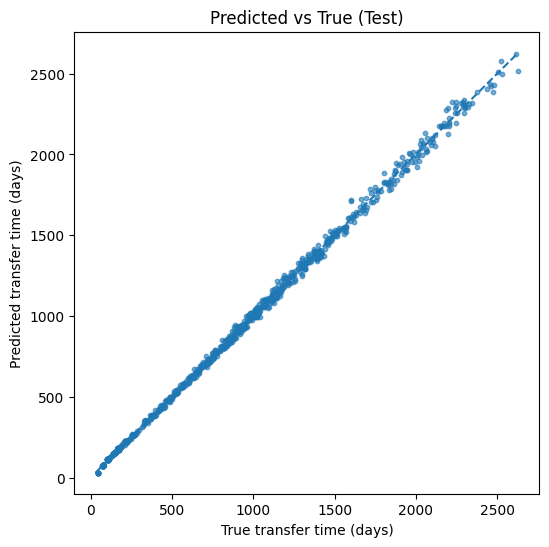

In [7]:
#@title 📈 Test evaluation (RMSE in days) + scatter plot
model.load_state_dict(torch.load("best_hohmann.pt", map_location=device))
model.eval()

def predict_denorm(Xn):
    with torch.no_grad():
        Xn_t = torch.from_numpy(Xn).to(device)
        yp_n = model(Xn_t).cpu().numpy()
    return yp_n * y_std + y_mean

y_pred_te = predict_denorm(X_te_n)
rmse_test = np.sqrt(np.mean((y_pred_te - y_te)**2))
print(f"Test RMSE: {rmse_test:.2f} days")

plt.figure(figsize=(6,6))
plt.scatter(y_te, y_pred_te, s=10, alpha=0.6)
mn = float(min(y_te.min(), y_pred_te.min()))
mx = float(max(y_te.max(), y_pred_te.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True transfer time (days)")
plt.ylabel("Predicted transfer time (days)")
plt.title("Predicted vs True (Test)")
plt.show()

What it is:
Friendly functions so you can query the model in natural ways: planets by name or custom radii in AU. They also print the physics baseline so you can compare model vs. truth instantly.

Key functions:

def normalize_inputs(X):
    return (X - x_mean) / x_std


Applies the training mean/std (saved from earlier) to new inputs. This is crucial: the model expects normalized features because that’s how it learned.

def predict_days(r1_au, r2_au):
    Xn = normalize_inputs(np.array([[r1_au, r2_au]], dtype=np.float32))
    yp = predict_denorm(Xn)[0,0]
    true = hohmann_transfer_time_days(r1_au, r2_au)
    return float(yp), float(true)


One-stop shop: normalize inputs, run the model, denormalize the output, and compute the exact physics number for comparison.

def predict_planets(p1, p2):
    r1 = PLANET_R_AU[p1]; r2 = PLANET_R_AU[p2]
    yp, yt = predict_days(r1, r2)
    print(f"{p1} ({r1} AU) → {p2} ({r2} AU)")
    print(f" Model: {yp:.1f} days | Physics: {yt:.1f} days | Abs err: {abs(yp-yt):.1f} days")


Convenience for well-known targets. Try a few and see if errors are tiny—if not, it hints at where the model is weaker.

Why it matters:
Inference code is what you’ll actually use in a script, a service, or a UI. It also demonstrates good hygiene:

Always apply the same preprocessing at inference that you used during training.

Provide reference values (here, the exact physics) when possible. It builds trust and makes debugging easy.

Common pitfalls avoided:

Using raw AU inputs directly with a model trained on normalized features (predictions will be nonsense).

Not aligning units (mixing AU and meters).

Swallowing exceptions on bad input (we include simple checks in the Gradio block).

In [8]:
#@title 🛰️ Inference: planet→planet or custom AU

def normalize_inputs(X):
    return (X - x_mean) / x_std

def predict_days(r1_au, r2_au):
    """Model prediction (days) + physics baseline for comparison."""
    Xn = normalize_inputs(np.array([[r1_au, r2_au]], dtype=np.float32))
    yp = predict_denorm(Xn)[0,0]
    true = hohmann_transfer_time_days(r1_au, r2_au)
    return float(yp), float(true)

def predict_planets(p1, p2):
    r1 = PLANET_R_AU[p1]
    r2 = PLANET_R_AU[p2]
    yp, yt = predict_days(r1, r2)
    print(f"{p1} ({r1} AU) → {p2} ({r2} AU)")
    print(f" Model: {yp:.1f} days | Physics: {yt:.1f} days | Abs err: {abs(yp-yt):.1f} days")

# Examples
predict_planets("Earth", "Mars")
predict_planets("Venus", "Jupiter")

# Custom values
yp, yt = predict_days(0.9, 1.7)
print(f"\nCustom 0.9 AU → 1.7 AU | Model: {yp:.1f} days | Physics: {yt:.1f} days")

Earth (1.0 AU) → Mars (1.524 AU)
 Model: 260.9 days | Physics: 258.9 days | Abs err: 2.0 days
Venus (0.723 AU) → Jupiter (5.204 AU)
 Model: 933.7 days | Physics: 931.7 days | Abs err: 2.0 days

Custom 0.9 AU → 1.7 AU | Model: 273.4 days | Physics: 270.7 days


What it is:
A tiny persistence layer so your trained model is reusable without retraining. You save:

The model weights (best_hohmann.pt).

The preprocessing constants (x_mean, x_std, y_mean, y_std) and the planet dictionary in preproc.json.

Code highlights:

artifacts = {
    "x_mean": x_mean.tolist(),
    "x_std":  x_std .tolist(),
    "y_mean": y_mean.tolist(),
    "y_std":  y_std .tolist(),
    "planet_r_au": PLANET_R_AU,
}
with open("preproc.json", "w") as f:
    json.dump(artifacts, f)


NumPy arrays aren’t directly JSON-serializable, so we use .tolist().

Reload sanity check:

with open("preproc.json") as f:
    art2 = json.load(f)
assert "x_mean" in art2 and "planet_r_au" in art2


Quick check that the file exists and has the keys we need.

Why it matters:
In the real world you deploy trained models, not training code. Saving preprocessing stats is critical: without the exact same normalization, the model’s outputs drift. Keeping them together avoids mismatches.

Common pitfalls avoided:

Only saving weights and forgetting the normalization constants.

Changing the preprocessing later and reusing old weights (silent accuracy drop).

Not versioning: consider naming files with timestamps or a semantic version if you iterate often.

In [ ]:
#@title 💾 Save/load artifacts
import json

artifacts = {
    "x_mean": x_mean.tolist(),
    "x_std":  x_std .tolist(),
    "y_mean": y_mean.tolist(),
    "y_std":  y_std .tolist(),
    "planet_r_au": PLANET_R_AU,
}
with open("preproc.json", "w") as f:
    json.dump(artifacts, f)

# Reload demo
with open("preproc.json") as f:
    art2 = json.load(f)
assert "x_mean" in art2 and "planet_r_au" in art2
print("Artifacts saved & sanity-checked.")

What it is:
A tiny web UI built with Gradio so anyone can play with the model in a browser: pick planets from dropdowns or type custom AU radii; the app prints Model vs Physics and the absolute error.

Code anatomy:

!pip -q install gradio==4.* > /dev/null
import gradio as gr


Installs and imports Gradio in Colab.

def ui_predict(p1, p2, r1, r2, use_planets):
    if use_planets:
        r1 = PLANET_R_AU[p1]; r2 = PLANET_R_AU[p2]
    else:
        if r1 <= 0 or r2 <= 0:
            return "Radii must be > 0 AU."
    yp, yt = predict_days(r1, r2)
    return (f"Inputs: r1={r1:.3f} AU, r2={r2:.3f} AU\n"
            f"Model:   {yp:.1f} days\n"
            f"Physics: {yt:.1f} days\n"
            f"Abs err: {abs(yp-yt):.1f} days")


Core function the UI calls. It supports two modes: (A) choose planets; (B) type custom radii. It validates inputs (no non-positive AU), calls your inference helper, and prints a neat, human-readable result.

demo = gr.Interface(
    fn=ui_predict,
    inputs=[Dropdown, Dropdown, Slider, Slider, Checkbox],
    outputs="text",
    title="Hohmann Transfer Time Learner",
    description="Choose planets or enter custom AU radii. Shows model vs physics time-of-flight.",
)
demo.launch()


A very small UI: two dropdowns for planets, two sliders for custom AU, and a toggle checkbox to choose which input method to use. Output is plain text (simple and robust).

Why it matters:
A hands-on panel makes the project feel alive. You can try Earth→Mars, Venus→Jupiter, or weird custom pairs in seconds. It also forces you to think about input validation and user experience—skills you need for real apps.

Common pitfalls avoided:

Launching the app without checking the model is loaded (we already loaded best weights earlier).

Not guarding invalid inputs (like r1 = -1).

Hiding differences between model and physics—showing both builds intuition and trust.

In [9]:
#@title 🧪 Gradio mini-app (optional)
!pip -q install gradio==4.* > /dev/null

import gradio as gr

def ui_predict(p1, p2, r1, r2, use_planets):
    if use_planets:
        try:
            r1 = PLANET_R_AU[p1]
            r2 = PLANET_R_AU[p2]
        except KeyError:
            return "Unknown planet name."
    else:
        if r1 <= 0 or r2 <= 0:
            return "Radii must be > 0 AU."
    yp, yt = predict_days(r1, r2)
    return (f"Inputs: r1={r1:.3f} AU, r2={r2:.3f} AU\n"
            f"Model:   {yp:.1f} days\n"
            f"Physics: {yt:.1f} days\n"
            f"Abs err: {abs(yp-yt):.1f} days")

demo = gr.Interface(
    fn=ui_predict,
    inputs=[
        gr.Dropdown(list(PLANET_R_AU.keys()), value="Earth", label="From planet"),
        gr.Dropdown(list(PLANET_R_AU.keys()), value="Mars", label="To planet"),
        gr.Slider(0.3, 6.0, value=1.0, step=0.001, label="Custom r1 (AU)"),
        gr.Slider(0.3, 6.0, value=1.5, step=0.001, label="Custom r2 (AU)"),
        gr.Checkbox(True, label="Use planet dropdowns"),
    ],
    outputs="text",
    title="Hohmann Transfer Time Learner",
    description="Choose planets or enter custom AU radii. Shows model vs physics time-of-flight.",
)
demo.launch(debug=False)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
yfinance 0.2.65 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
google-genai 1.33.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4a788f1b035cb290dd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio d